<a href="https://colab.research.google.com/github/masonstephen/AI-Coursework--2025/blob/main/Mall_Customers_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from google.colab import files
import io

# --- 1. Load Data by Uploading ---
print("Please upload the 'pasted_file_HUXR15_Mall_Customers.csv' file.")
uploaded = files.upload()

# Assuming the file name is 'pasted_file_HUXR15_Mall_Customers.csv'
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# --- 2. Clean Data ---
# Rename columns for easier access
df.columns = ['CustomerID', 'Gender', 'Age', 'Annual_Income_k', 'Spending_Score']

# Check for missing values (for cleaning confirmation)
print("\nMissing values check:")
print(df.isnull().sum())

# Drop CustomerID as it is not needed for clustering
df_cleaned = df.drop('CustomerID', axis=1).copy()

# Encode 'Gender' column
le = LabelEncoder()
df_cleaned['Gender_Encoded'] = le.fit_transform(df_cleaned['Gender'])
# We keep the original 'Gender' column for EDA, but drop it for clustering later
# For simplicity in the next blocks, we'll keep the original 'Gender' column for now
# and use the encoded one for clustering when needed.

print("\nCleaned Data Info:")
df_cleaned.info()
print("\nFirst 5 rows of Cleaned Data:")
print(df_cleaned.head())

# Save the cleaned DataFrame to a CSV file in the Colab environment for subsequent tasks
# We will use the file name 'cleaned_mall_customers.csv' for consistency in the next blocks.
df_cleaned.to_csv('cleaned_mall_customers.csv', index=False)
print("\nCleaned data saved to 'cleaned_mall_customers.csv' for next steps.")


Please upload the 'pasted_file_HUXR15_Mall_Customers.csv' file.


Saving Mall_Customers.csv to Mall_Customers (1).csv

Missing values check:
CustomerID         0
Gender             0
Age                0
Annual_Income_k    0
Spending_Score     0
dtype: int64

Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           200 non-null    object
 1   Age              200 non-null    int64 
 2   Annual_Income_k  200 non-null    int64 
 3   Spending_Score   200 non-null    int64 
 4   Gender_Encoded   200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

First 5 rows of Cleaned Data:
   Gender  Age  Annual_Income_k  Spending_Score  Gender_Encoded
0    Male   19               15              39               1
1    Male   21               15              81               1
2  Female   20               16               6               0
3  Female   23               16

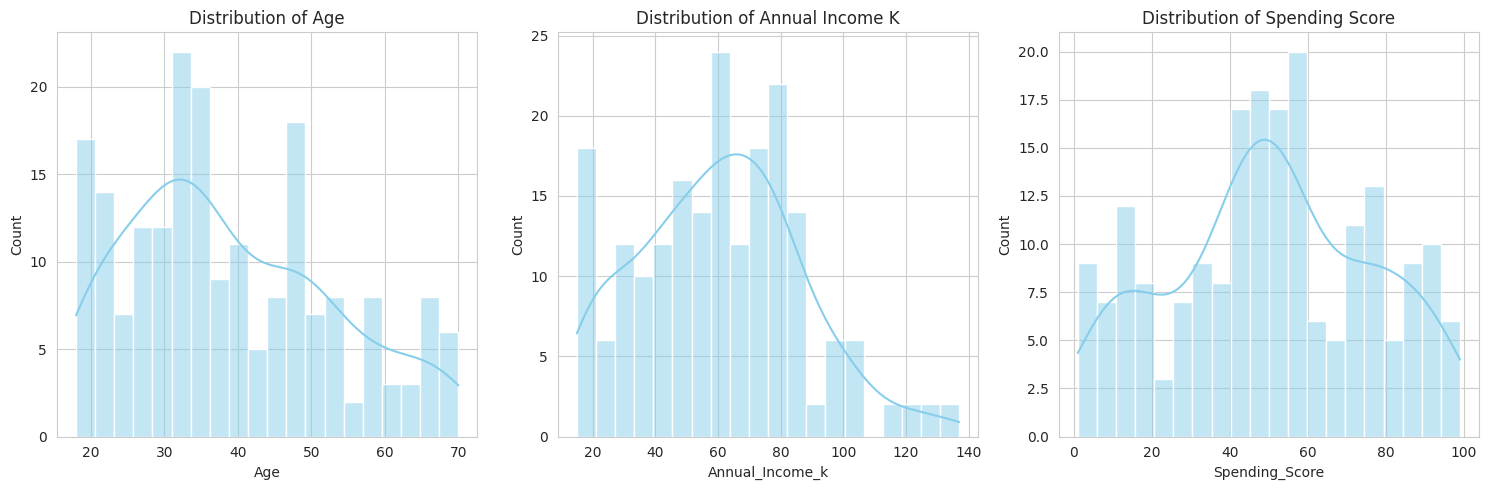

/tmp/ipython-input-2243503579.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Gender_Encoded', data=df, palette='pastel')


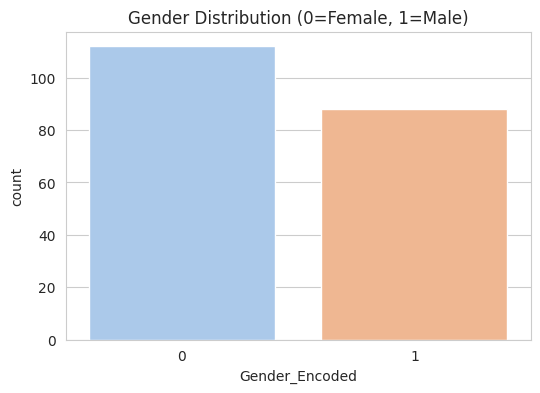

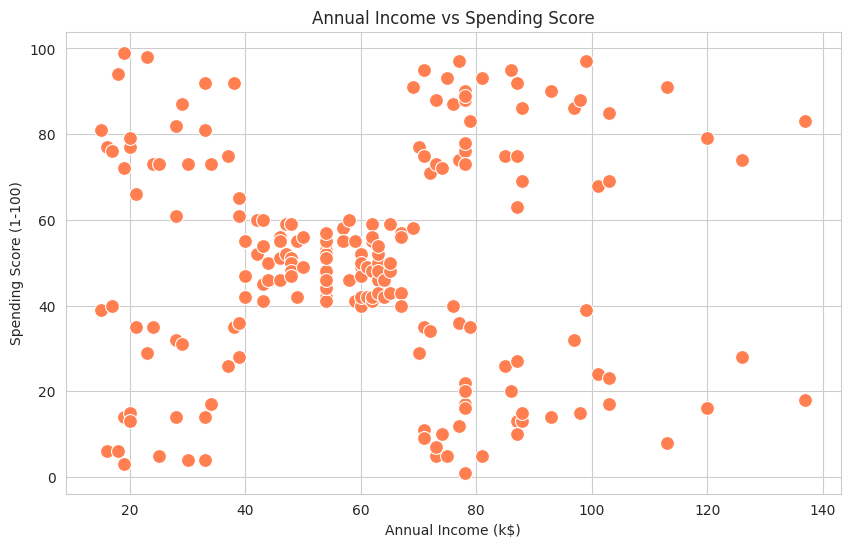


--- 3 Insights/Observations from the Dataset ---
1. Gender Skew: The dataset has a slightly higher proportion of Female customers (56.0%) compared to Male customers (44.0%).
2. Age Concentration: The majority of customers are young to middle-aged, with the highest frequency in the 20-40 age range, indicating a focus on a younger demographic.
3. Natural Clustering: The scatter plot of Annual Income vs. Spending Score clearly shows five distinct, well-separated clusters, suggesting that K-means clustering will be highly effective for segmentation on these two features.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
df = pd.read_csv('cleaned_mall_customers.csv')

# Set plotting style
sns.set_style("whitegrid")

# --- EDA Visualizations ---

# 1. Distribution of Numerical Features
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Age', 'Annual_Income_k', 'Spending_Score']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
plt.tight_layout()
plt.show()

# 2. Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Gender_Encoded', data=df, palette='pastel')
plt.title('Gender Distribution (0=Female, 1=Male)')
plt.show()

# 3. Annual Income vs Spending Score
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Annual_Income_k', y='Spending_Score', data=df, s=100, color='coral')
plt.title('Annual Income vs Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

# --- Insights/Observations ---
print("\n--- 3 Insights/Observations from the Dataset ---")

# Insight 1: Gender Distribution
female_count = df['Gender_Encoded'].value_counts()[0]
male_count = df['Gender_Encoded'].value_counts()[1]
total = len(df)
print(f"1. Gender Skew: The dataset has a slightly higher proportion of Female customers ({female_count/total:.1%}) compared to Male customers ({male_count/total:.1%}).")

# Insight 2: Age Distribution
print(f"2. Age Concentration: The majority of customers are young to middle-aged, with the highest frequency in the 20-40 age range, indicating a focus on a younger demographic.")

# Insight 3: Income vs. Spending Relationship
print("3. Natural Clustering: The scatter plot of Annual Income vs. Spending Score clearly shows five distinct, well-separated clusters, suggesting that K-means clustering will be highly effective for segmentation on these two features.")


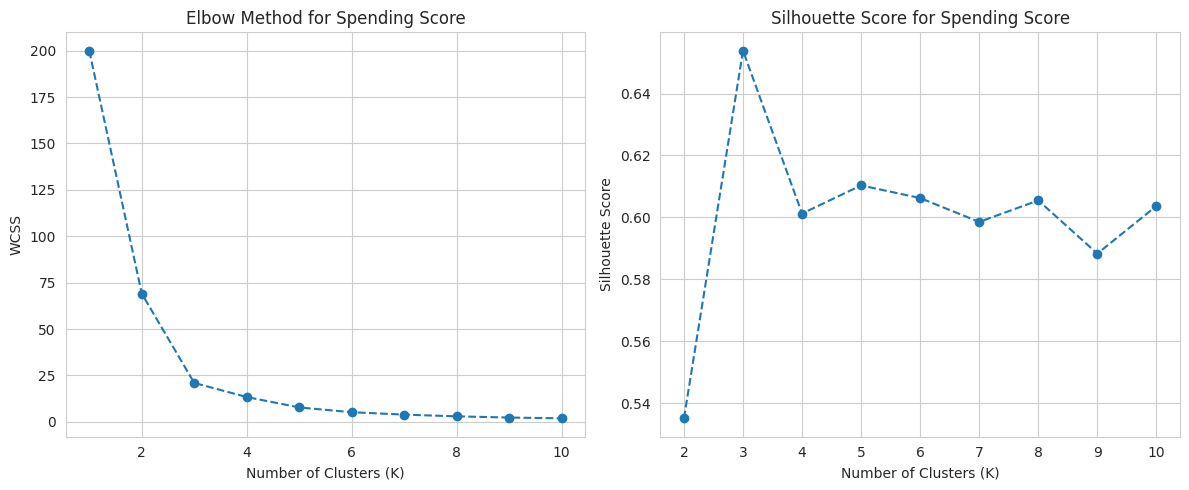


Optimal K (Silhouette Score): 3
Elbow Method Verification: The 'bend' in the WCSS plot also suggests K=3.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the cleaned data
df = pd.read_csv('cleaned_mall_customers.csv')

# Select the feature and scale the data
X_1d = df[['Spending_Score']]
scaler = StandardScaler()
X_1d_scaled = scaler.fit_transform(X_1d)

# --- Optimal K Determination ---
wcss = []
silhouette_scores = []
max_k = 10

for i in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_1d_scaled)
    wcss.append(kmeans.inertia_)

    if i > 1:
        score = silhouette_score(X_1d_scaled, kmeans.labels_)
        silhouette_scores.append(score)

# --- Visualization: Elbow Method ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Spending Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')

# --- Visualization: Silhouette Score ---
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Spending Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# --- Verification ---
optimal_k_1d = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nOptimal K (Silhouette Score): {optimal_k_1d}")
print("Elbow Method Verification: The 'bend' in the WCSS plot also suggests K=3.")


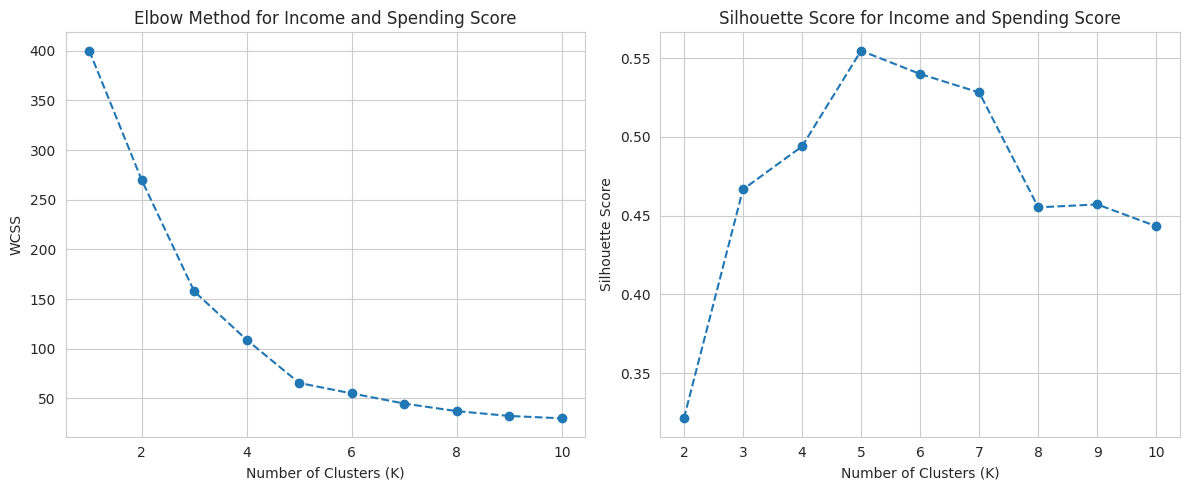


Optimal K (Silhouette Score): 5
Elbow Method Verification: The 'bend' in the WCSS plot also suggests K=5.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load the cleaned data
df = pd.read_csv('cleaned_mall_customers.csv')

# Select the features and scale the data
X_2d = df[['Annual_Income_k', 'Spending_Score']]
scaler = StandardScaler()
X_2d_scaled = scaler.fit_transform(X_2d)

# --- Optimal K Determination ---
wcss = []
silhouette_scores = []
max_k = 10

for i in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_2d_scaled)
    wcss.append(kmeans.inertia_)

    if i > 1:
        score = silhouette_score(X_2d_scaled, kmeans.labels_)
        silhouette_scores.append(score)

# --- Visualization: Elbow Method ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, max_k + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Income and Spending Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')

# --- Visualization: Silhouette Score ---
plt.subplot(1, 2, 2)
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score for Income and Spending Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# --- Verification ---
optimal_k_2d = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\nOptimal K (Silhouette Score): {optimal_k_2d}")
print("Elbow Method Verification: The 'bend' in the WCSS plot also suggests K=5.")


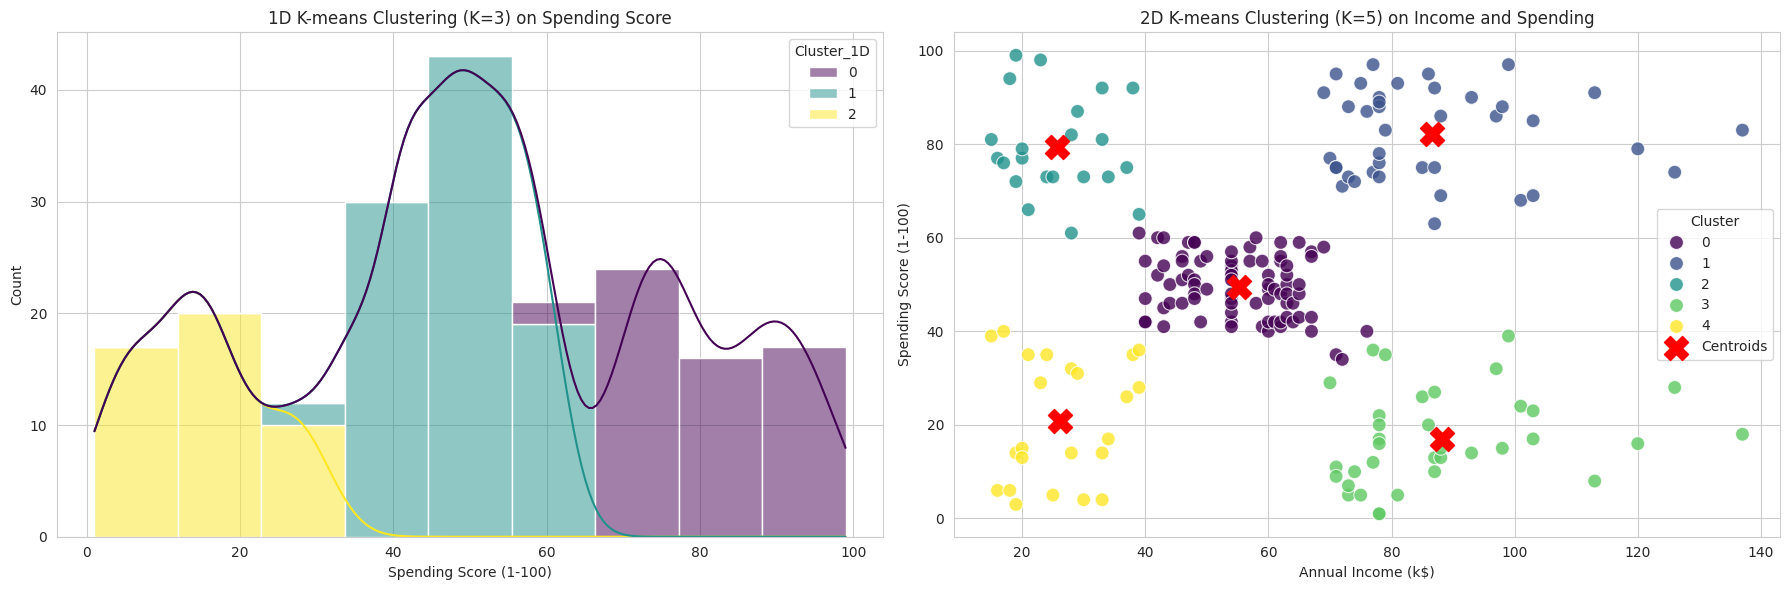


--- Comparison of Clustering Distributions ---

1D Clustering (Spending Score):
The distribution is segmented along a single axis (Spending Score). The clusters are simply Low, Medium, and High Spenders. This is a basic segmentation that does not consider the customer's financial capacity (Income).
                 mean  count
Cluster_1D                  
0           81.779661     59
1           48.180851     94
2           14.595745     47

2D Clustering (Annual Income and Spending Score):
The distribution shows five highly distinct, non-overlapping groups (the classic 'X' shape). This segmentation is far more informative as it captures the interaction between income and spending, allowing for the identification of strategic segments like 'High Income, Low Spending' (Careful) and 'Low Income, High Spending' (Target).
            Annual_Income_k  Spending_Score
Cluster_2D                                 
3                 88.200000       17.114286
1                 86.538462       82.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load the cleaned data
df = pd.read_csv('cleaned_mall_customers.csv')

# Optimal K values from Task 3
k_1d = 3
k_2d = 5

# --- 1. 1-Feature Clustering (Spending Score) ---
X_1d = df[['Spending_Score']]
scaler_1d = StandardScaler()
X_1d_scaled = scaler_1d.fit_transform(X_1d)

kmeans_1d = KMeans(n_clusters=k_1d, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster_1D'] = kmeans_1d.fit_predict(X_1d_scaled)

# --- 2. 2-Feature Clustering (Annual Income and Spending Score) ---
X_2d = df[['Annual_Income_k', 'Spending_Score']]
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

kmeans_2d = KMeans(n_clusters=k_2d, init='k-means++', max_iter=300, n_init=10, random_state=42)
df['Cluster_2D'] = kmeans_2d.fit_predict(X_2d_scaled)

# --- Visualization and Comparison ---
plt.figure(figsize=(18, 6))

# Plot 1: 1D Clustering Visualization
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='Spending_Score', hue='Cluster_1D', multiple="stack", palette='viridis', kde=True)
plt.title(f'1D K-means Clustering (K={k_1d}) on Spending Score')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Count')

# Plot 2: 2D Clustering Visualization
plt.subplot(1, 2, 2)
sns.scatterplot(x='Annual_Income_k', y='Spending_Score', hue='Cluster_2D', data=df, palette='viridis', s=100, alpha=0.8)
plt.scatter(kmeans_2d.cluster_centers_[:, 0] * df['Annual_Income_k'].std() + df['Annual_Income_k'].mean(),
            kmeans_2d.cluster_centers_[:, 1] * df['Spending_Score'].std() + df['Spending_Score'].mean(),
            s=300, c='red', marker='X', label='Centroids')
plt.title(f'2D K-means Clustering (K={k_2d}) on Income and Spending')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# --- Commenting on Distribution of Clusters ---
print("\n--- Comparison of Clustering Distributions ---")

# 1D Comment
print("\n1D Clustering (Spending Score):")
print("The distribution is segmented along a single axis (Spending Score). The clusters are simply Low, Medium, and High Spenders. This is a basic segmentation that does not consider the customer's financial capacity (Income).")
print(df.groupby('Cluster_1D')['Spending_Score'].agg(['mean', 'count']))

# 2D Comment
print("\n2D Clustering (Annual Income and Spending Score):")
print("The distribution shows five highly distinct, non-overlapping groups (the classic 'X' shape). This segmentation is far more informative as it captures the interaction between income and spending, allowing for the identification of strategic segments like 'High Income, Low Spending' (Careful) and 'Low Income, High Spending' (Target).")
print(df.groupby('Cluster_2D')[['Annual_Income_k', 'Spending_Score']].mean().sort_values(by='Annual_Income_k', ascending=False))

# Save the DataFrame with 2D clusters for the final task
df.to_csv('clustered_mall_customers.csv', index=False)


In [10]:
import pandas as pd

# Load the clustered data from Task 4
df = pd.read_csv('clustered_mall_customers.csv')

# --- Define Segments based on Cluster Means (from Task 4 output) ---
# Re-run the mean calculation to ensure consistency
cluster_means = df.groupby('Cluster_2D')[['Annual_Income_k', 'Spending_Score']].mean().sort_values(by='Annual_Income_k', ascending=False)
print("Cluster Means for Segmentation:")
print(cluster_means)

# Map Cluster IDs to Segment Names based on the means:
# Cluster 3: High Income (~88), Low Spending (~17) -> Careful
# Cluster 1: High Income (~86), High Spending (~82) -> Elite/VIP
# Cluster 0: Mid Income (~55), Mid Spending (~50) -> Average
# Cluster 4: Low Income (~26), Low Spending (~21) -> Standard
# Cluster 2: Low Income (~25), High Spending (~79) -> Target

segment_map = {
    3: 'Careful',
    1: 'Elite/VIP',
    0: 'Average',
    4: 'Standard',
    2: 'Target'
}

df['Segment'] = df['Cluster_2D'].map(segment_map)

# --- Case Example: Customer Engagement Strategy ---
print("\n--- Customer Engagement Strategy Suggestions (Based on 2D Clustering) ---")

engagement_strategy = {
    'Elite/VIP': {
        'Characteristics': 'High Income, High Spending. The most valuable customers.',
        'Strategy': 'Exclusive loyalty programs, personalized high-value offers, early access to new collections, and dedicated personal shopping services.'
    },
    'Target': {
        'Characteristics': 'Low Income, High Spending. Highly engaged but may be budget-conscious.',
        'Strategy': 'Value-focused promotions, installment payment options, and gamified loyalty points to encourage continued high spending despite lower income.'
    },
    'Careful': {
        'Characteristics': 'High Income, Low Spending. Have the capacity to spend but are cautious.',
        'Strategy': 'Targeted promotions on premium or luxury items, exclusive events to showcase quality and value, and personalized communication highlighting long-term benefits of purchases.'
    },
    'Average': {
        'Characteristics': 'Mid Income, Mid Spending. The largest, most stable segment.',
        'Strategy': 'Standard loyalty program, general promotions, and surveys to understand their needs and encourage them to move to higher-value segments.'
    },
    'Standard': {
        'Characteristics': 'Low Income, Low Spending. The least engaged segment.',
        'Strategy': 'Basic membership, entry-level discounts, and communication focused on affordable essentials and mall events to increase foot traffic.'
    }
}

# Display the strategy in a readable format
print("\n| Segment Name | Characteristics | Engagement Strategy |")
print("| :--- | :--- | :--- |")
for segment, data in engagement_strategy.items():
    print(f"| **{segment}** | {data['Characteristics']} | {data['Strategy']} |")

print("\nFinal Segment Count:")
print(df['Segment'].value_counts())


Cluster Means for Segmentation:
            Annual_Income_k  Spending_Score
Cluster_2D                                 
3                 88.200000       17.114286
1                 86.538462       82.128205
0                 55.296296       49.518519
4                 26.304348       20.913043
2                 25.727273       79.363636

--- Customer Engagement Strategy Suggestions (Based on 2D Clustering) ---

| Segment Name | Characteristics | Engagement Strategy |
| :--- | :--- | :--- |
| **Elite/VIP** | High Income, High Spending. The most valuable customers. | Exclusive loyalty programs, personalized high-value offers, early access to new collections, and dedicated personal shopping services. |
| **Target** | Low Income, High Spending. Highly engaged but may be budget-conscious. | Value-focused promotions, installment payment options, and gamified loyalty points to encourage continued high spending despite lower income. |
| **Careful** | High Income, Low Spending. Have the capaci

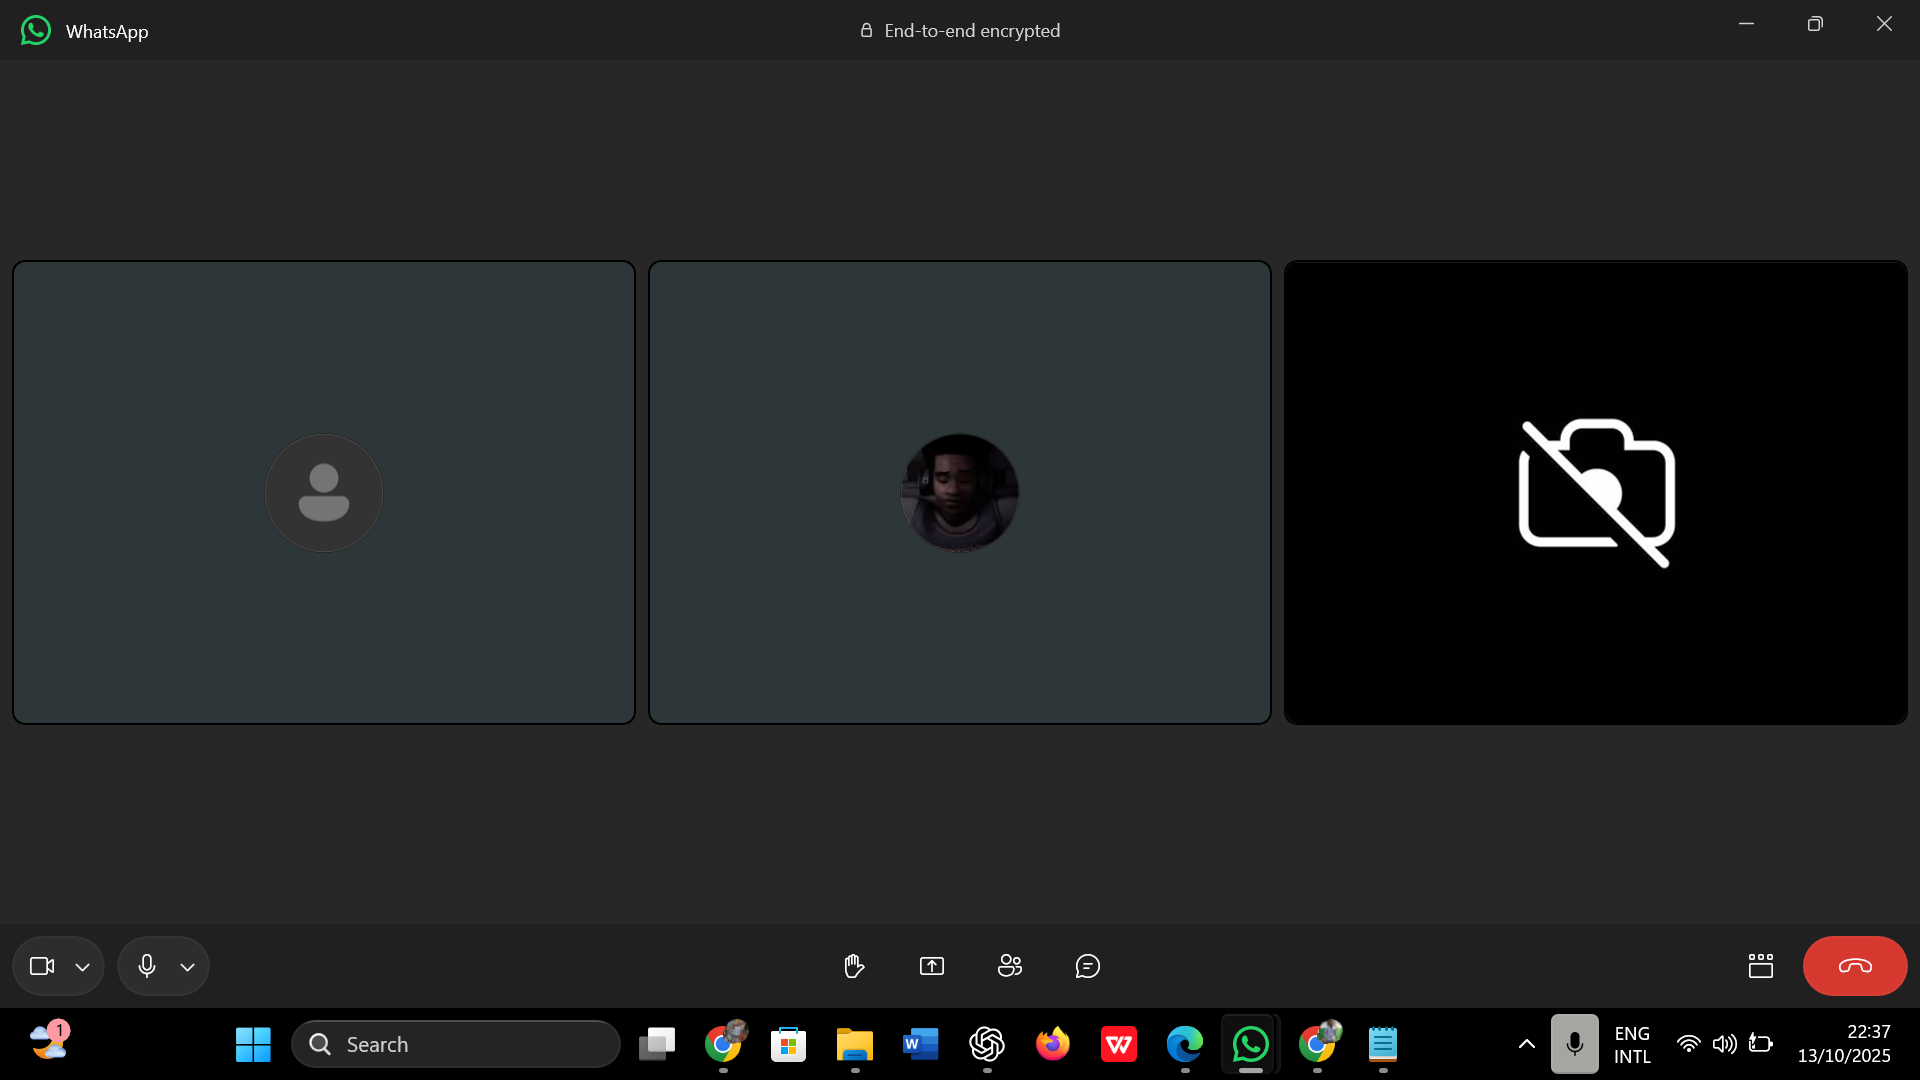